## Things to analyse
- Visualise Metrics - Done
- For single image use ScoreCAM, GradCAM and analyse the metrics - Done
- Check for cases where the metric is misleading in bunch of images
- Validate metric characteristics

### Visualise Metrics

In [1]:
import os
os.chdir("..")

In [2]:
from commons.api.utils import set_to_our_gpus, enable_web_access
set_to_our_gpus()
enable_web_access()

In [3]:
!nvidia-smi

Mon Oct 16 13:10:54 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off | 00000000:B1:00.0 Off |                  N/A |
| 22%   24C    P8               9W / 250W |   2231MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
from PIL import Image
from numpy import random
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.spatial.distance import cdist
from pyemd import emd
import tensorflow as tf
from cv2 import EMD
# from ScoreCAM import cam

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torchvision.utils import save_image

from ultralytics import YOLO
from api.metrics import apply_grey_patch, add_random_noise_to_image
from api.metrics import normalize, match_hist, normalize_map #metrics preprocessing
from api.metrics import SIM, CC, NSS, AUC_Judd

from commons.api.imagenet_tiny import get_imagenet_classes, get_random_images

from commons.ScoreCAM.cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp, ScoreCAM
from commons.ScoreCAM.utils.visualize import visualize, reverse_normalize
from commons.ScoreCAM.utils.imagenet_labels import label2idx, idx2label

import scipy.stats as sci 

2023-10-16 13:11:02.355105: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 13:11:08.836095: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.3/lib64:/scratch/shkulkar/python/lib:/usr/local/cuda-11.3/tensorRT-8.0/lib64:/usr/local/cuda-11.3/cudnn-8.2/lib64:/usr/local/cuda-11.3/nccl-2.9/lib64
2023-10-16 13:11:08.836457: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object fil

In [9]:
# os.environ['CUDA_VISIBLE_DEVICES'] = "1,3"
# ngpu = torch.cuda.device_count()
# for gpu_id in range(ngpu):
#     gpu = torch.cuda.get_device_name(gpu_id)
#     print(f"GPU:{gpu_id} {gpu}")

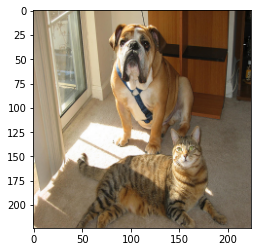

In [7]:
image = Image.open('/project/validating_attribution_techniques/commons/examples/input.png')
# image = keras.utils.get_file("cat_and_dog.jpg", "https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg",)
imshow(image)

In [11]:
# sample_images, sample_labels = get_random_images(200)
# sample_images = [np.array(Image.fromarray(image).resize((224, 224))) for image in sample_images]

# idx = 1
# plt.imshow(sample_images[idx])
# print(classes[sample_labels[idx]])

In [8]:
def preprocessing(image):
    # Resize the image
    size = (300, 300)
    image = image.resize(size)
    
    # preprocessing. mean and std from ImageNet
    normalize = transforms.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
    )

    preprocess = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    # convert image to tensor
    tensor = preprocess(image)

    # reshape 4D tensor (N, C, H, W)
    tensor = tensor.unsqueeze(0)
    
    return tensor

In [9]:
tensor = preprocessing(image)
tensor.shape

torch.Size([1, 3, 300, 300])

In [10]:
tensor_gpu_grad = tensor.clone()
tensor_gpu_score = tensor.detach()
# tensor_cpu_smooth = tensor.detach()

In [11]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
model_gpu = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)
# model_cpu = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model_gpu.eval()

Using cache found in /home/shkulkar/.cache/torch/hub/pytorch_vision_v0.10.0
/scratch/shkulkar/python/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/scratch/shkulkar/python/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
gpu_reference_tensor = next(model_gpu.parameters())
tensor_gpu_grad = tensor_gpu_grad.type_as(gpu_reference_tensor)
tensor_gpu_score = tensor_gpu_score.type_as(gpu_reference_tensor)

In [13]:
target_layer_gpu = model_gpu.layer4[1].conv2
# target_layer_cpu = model_cpu.layer4[1].conv2
classes = open("/project/validating_attribution_techniques/shardul/classes.txt").read().splitlines()

In [14]:
def smoothGradCAMpp(target_layer, model, tensor):
    # Create an instance of SmoothGradCAMpp
    wrapped_model = SmoothGradCAMpp(model, target_layer)
    
    # Call SmoothGradCAMpp without the tensor argument
    cam, idx = wrapped_model(tensor)
    
    return cam, idx


In [15]:
def gradCAM(target_layer, model, tensor):
    wrapped_model = GradCAM(model, target_layer)
    cam, idx = wrapped_model(tensor)
    return cam, idx

In [16]:
def scoreCAM(target_layer, model, tensor):
    wrapped_model = ScoreCAM(model, target_layer)
    cam, idx = wrapped_model(tensor)
    return cam, idx

In [17]:
def saliency_map(tensor, cam):
#     tensor = tensor.cpu()
    img = reverse_normalize(tensor)
    heatmap = visualize(img, cam)
    heatmap_saliency = np.transpose(heatmap.squeeze(), (1, 2, 0))
    return heatmap_saliency

def saliency_map_cpu(tensor, cam):
#     tensor = tensor.cpu()
    img = reverse_normalize(tensor)
    heatmap = visualize(img, cam)
    heatmap = np.transpose(heatmap.squeeze(), (1, 2, 0))
    return heatmap

In [18]:
Gradcam, grad_idx = gradCAM(target_layer_gpu, model_gpu, tensor_gpu_grad)
Gradcam = Gradcam.cpu()

/scratch/shkulkar/python/lib/python3.8/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


predicted class ids 243	 probability 0.09924974292516708


Text(0.5, 1.0, 'Class: bull mastiff(9.92%)')

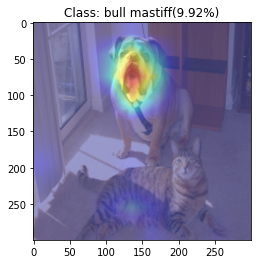

In [19]:
fig, ax = plt.subplots()
with torch.no_grad():
  output_grad = model_gpu(tensor_gpu_grad)
  class_grad = torch.argmax(output_grad).item()
  prob_grad = torch.softmax(output_grad, dim=1)[0, class_grad].item()
grad_heatmap = saliency_map(tensor_gpu_grad, Gradcam)
ax.imshow(grad_heatmap, cmap='turbo', alpha = 0.8)
ax.set_title(f"Class: {idx2label[grad_idx]}({prob_grad*100:.2f}%)")

In [24]:
# os.environ['CUDA_VISIBLE_DEVICES'] = "1,3"
# ngpu = torch.cuda.device_count()
# for gpu_id in range(ngpu):
#     gpu = torch.cuda.get_device_name(gpu_id)
#     print(f"GPU:{gpu_id} {gpu}")

In [26]:
scorecam, score_idx = scoreCAM(target_layer_gpu, model_gpu, tensor_gpu_score)
scorecam = scorecam.cpu()

Text(0.5, 1.0, 'Class: bull mastiff(9.92%)')

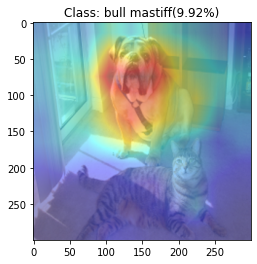

In [27]:
fig, ax = plt.subplots()
with torch.no_grad():
  output_score = model_gpu(tensor_gpu_score)
  class_score = torch.argmax(output_score).item()
  prob_score = torch.softmax(output_score, dim=1)[0, class_score].item()
heatmap = saliency_map(tensor_gpu_score, scorecam)
ax.imshow(heatmap, cmap='turbo', alpha = 0.8)
ax.set_title(f"Class: {idx2label[score_idx]}({prob_score*100:.2f}%)")

In [28]:
#Creating the patch
PATCH_SIZE = 60
def apply_grey_patch(path, image, top_left_x, top_left_y, patch_size):
    patched_image = np.array(image, copy=True)
    patched_image[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size, :] = 0
    img = keras.preprocessing.image.array_to_img(patched_image)
    print(path)
    img.save(path)
    print(np.shape(patched_image))
    return patched_image

In [29]:
# #Putting the patch over the image
# image_path = "/project/validating_attribution_techniques/commons/examples/input.png"
# image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
# image = tf.keras.preprocessing.image.img_to_array(image)

# i = 0
# # Iterate the patch over the image
# for top_left_x in range(0, image.shape[0], PATCH_SIZE):
#     for top_left_y in range(0, image.shape[1], PATCH_SIZE):
#         # Apply the patch and display the image
#         path = "/home/smitra/project/validating_attribution_techniques/saikat/Source_images/Occluded_images/occluded_img_" + str(i) + ".jpg"
#         i+=1
#         patched_image = apply_grey_patch(path,image, top_left_x, top_left_y, PATCH_SIZE)
#         patched_image = patched_image.astype('float32') / 255.0
# #         n_patched_image 

In [30]:
dir_path = "/home/shkulkar/project/validating_attribution_techniques/shardul/output/noisy_images/occlusion/"
count = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count += 1
print('File count:', count)

File count: 16


In [31]:
def wasserstein_distance(cam, perturbed_cam, method):
    # Ensure that the tensors have the same shape
    if method == "GradCAM":
        if cam.shape != perturbed_cam.shape:
            raise ValueError("Both input tensors must have the same shape")

        # Reshape the tensors
        saliency_map1 = np.array(cam.reshape(-1))
        saliency_map2 = np.array(perturbed_cam.reshape(-1))

        emd = sci.wasserstein_distance(saliency_map1, saliency_map2)
        return emd
    elif method == "ScoreCAM":
        emd = EMD(np.reshape(cam.numpy(),(300,300)), np.reshape(perturbed_cam.numpy(),(300,300)), 1)
#         print(type(emd))
        return emd[0]


# import cv2
# import numpy as np

# def wasserstein_distance(cam, perturbed_cam):
#     # Ensure that the tensors have the same shape
#     if cam.shape != perturbed_cam.shape:
#         raise ValueError("Both input tensors must have the same shape")

#     # Convert PyTorch tensors to NumPy arrays and reshape them to 1D arrays
#     saliency_map1 = cam.cpu().detach().numpy().reshape(-1).astype(np.float32)
#     saliency_map2 = perturbed_cam.cpu().detach().numpy().reshape(-1).astype(np.float32)

#     # Create histograms (probability density functions) in the expected format
#     hist1 = cv2.calcHist([saliency_map1], [0], None, [256], [0, 1], cv2.CV_32FC1)
#     hist2 = cv2.calcHist([saliency_map2], [0], None, [256], [0, 1], cv2.CV_32FC1)

#     # Calculate the EMD (Earth Mover's Distance)
#     emd = cv2.EMD(hist1, hist2, cv2.DIST_L2)

#     return emd



In [32]:
def SIM(saliency_map1, saliency_map2):
    '''
    Similarity between two different saliency maps when viewed as distributions
    (SIM=1 means the distributions are identical).

    This similarity measure is also called **histogram intersection**.

    Parameters
    ----------
    saliency_map1 : real-valued matrix
        If the two maps are different in shape, saliency_map1 will be resized to match saliency_map2.
    saliency_map2 : real-valued matrix

    Returns
    -------
    SIM : float, between [0,1]
    '''
    map1 = np.array(saliency_map1, copy=False)
    map2 = np.array(saliency_map2, copy=False)
    if map1.shape != map2.shape:
        map1 = resize(map1, map2.shape, order=3, mode='nearest') # bi-cubic/nearest is what Matlab imresize() does by default
    # Normalize the two maps to have values between [0,1] and sum up to 1
    map1 = normalize(map1, method='range')
    map2 = normalize(map2, method='range')
    map1 = normalize(map1, method='sum')
    map2 = normalize(map2, method='sum')
    # Compute histogram intersection
    intersection = np.minimum(map1, map2)
    return np.sum(intersection)

def CC(saliency_map1, saliency_map2):
    '''
    Pearson's correlation coefficient between two different saliency maps
    (CC=0 for uncorrelated maps, CC=1 for perfect linear correlation).

    Parameters
    ----------
    saliency_map1 : real-valued matrix
        If the two maps are different in shape, saliency_map1 will be resized to match saliency_map2.
    saliency_map2 : real-valued matrix

    Returns
    -------
    CC : float, between [-1,1]
    '''
    map1 = np.array(saliency_map1, copy=False)
    map2 = np.array(saliency_map2, copy=False)
    if map1.shape != map2.shape:
        map1 = resize(map1, map2.shape, order=3, mode='nearest') # bi-cubic/nearest is what Matlab imresize() does by default
    # Normalize the two maps to have zero mean and unit std
    map1 = normalize(map1, method='standard')
    map2 = normalize(map2, method='standard')
    # Compute correlation coefficient
    return np.corrcoef(map1.ravel(), map2.ravel())[0,1]

def NSS(saliency_map, fixation_map):
    '''
    Normalized scanpath saliency of a saliency map,
    defined as the mean value of normalized (i.e., standardized) saliency map at fixation locations.
    You can think of it as a z-score. (Larger value implies better performance.)

    Parameters
    ----------
    saliency_map : real-valued matrix
        If the two maps are different in shape, saliency_map will be resized to match fixation_map..
    fixation_map : binary matrix
        Human fixation map (1 for fixated location, 0 for elsewhere).

    Returns
    -------
    NSS : float, positive
    '''
    s_map = np.array(saliency_map, copy=False)
    f_map = np.array(fixation_map, copy=False) > 0.5
    if s_map.shape != f_map.shape:
        s_map = resize(s_map, f_map.shape)
    # Normalize saliency map to have zero mean and unit std
    s_map = normalize(s_map, method='standard')
    # Mean saliency value at fixation locations
    return np.mean(s_map[f_map])



In [33]:
def calculate_metrics(cam, perturbed_cam, method):
    sim = SIM(cam, perturbed_cam)
    cc = CC(cam, perturbed_cam)
    nss = NSS(cam, perturbed_cam)
#     auc_judd = AUC_Judd(cam, perturbed_cam)
#     auc_borji = AUC_Borji(cam, perturbed_cam)
    emd = wasserstein_distance(cam, perturbed_cam, method)
    return sim, cc, nss, emd

predicted class ids 243	 probability 0.1791817545890808
Iteration 0 of / 16


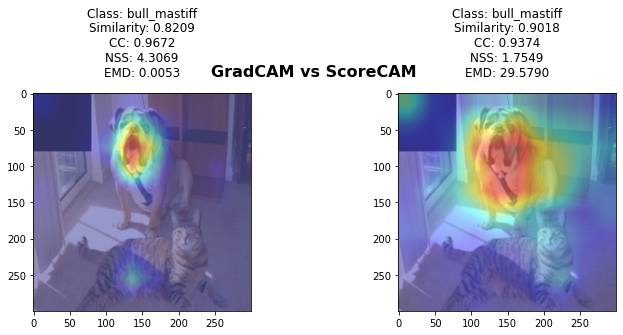

predicted class ids 243	 probability 0.2023897022008896
Iteration 1 of / 16


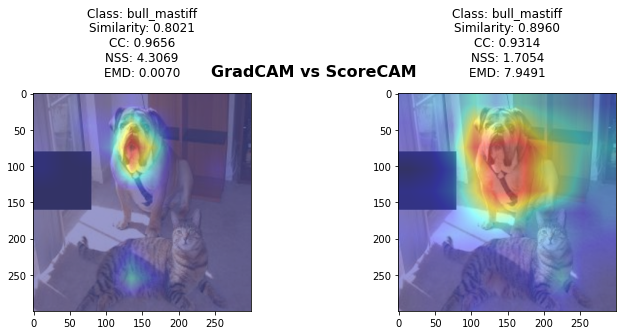

predicted class ids 243	 probability 0.20393875241279602
Iteration 2 of / 16


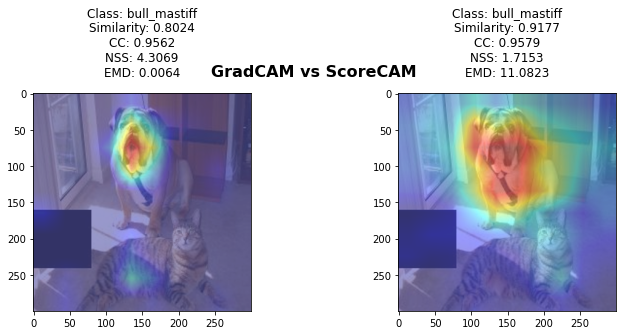

predicted class ids 243	 probability 0.23570838570594788
Iteration 3 of / 16


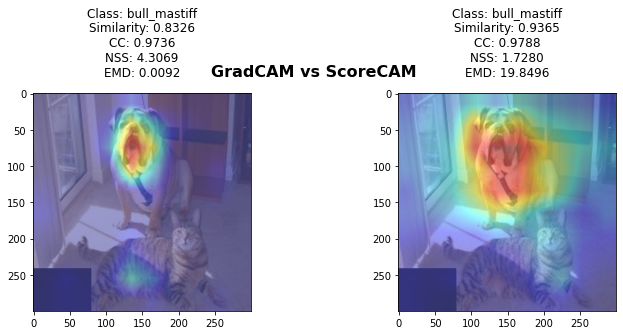

predicted class ids 281	 probability 0.1075863316655159
Iteration 4 of / 16


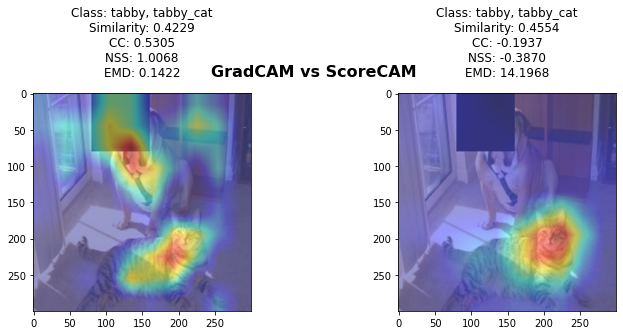

predicted class ids 282	 probability 0.16916877031326294
Iteration 5 of / 16


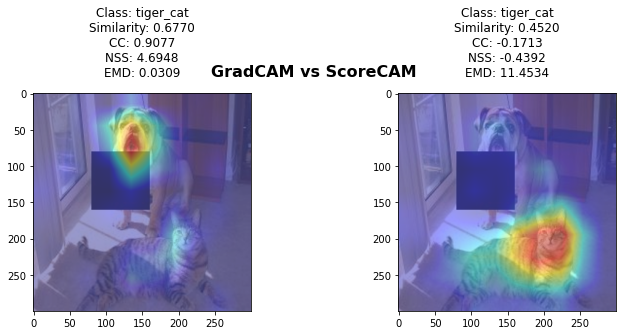

predicted class ids 243	 probability 0.20668654143810272
Iteration 6 of / 16


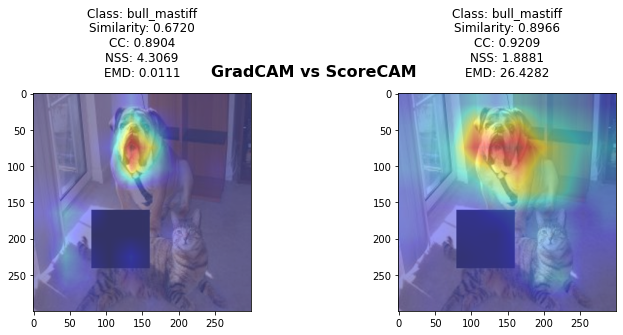

predicted class ids 243	 probability 0.25450971722602844
Iteration 7 of / 16


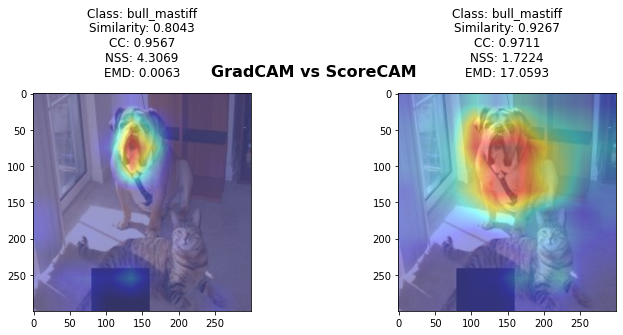

predicted class ids 243	 probability 0.1827351152896881
Iteration 8 of / 16


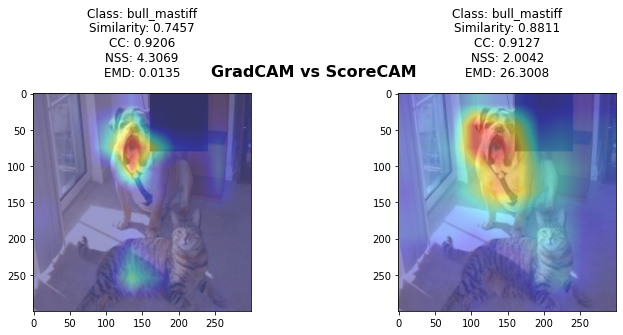

predicted class ids 243	 probability 0.191214457154274
Iteration 9 of / 16


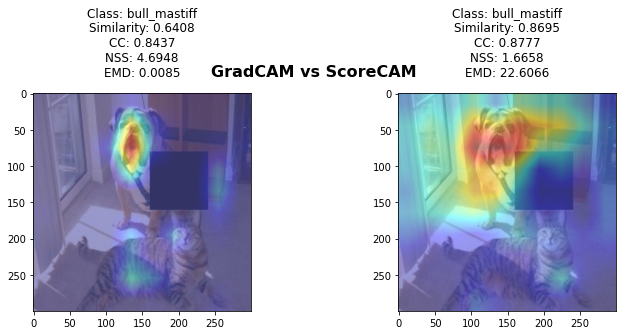

predicted class ids 243	 probability 0.19486495852470398
Iteration 10 of / 16


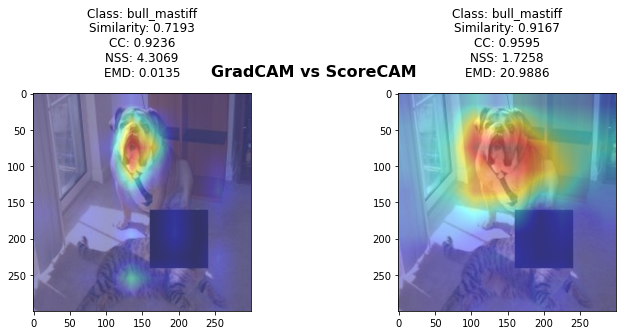

predicted class ids 243	 probability 0.20261329412460327
Iteration 11 of / 16


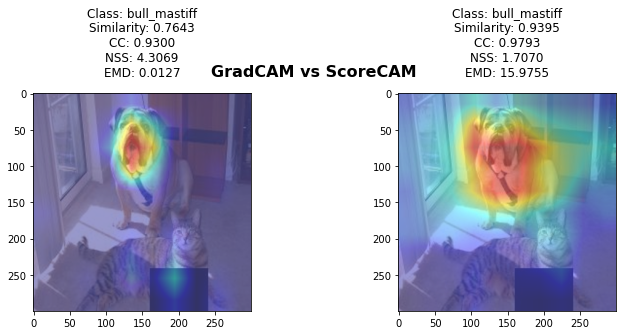

predicted class ids 243	 probability 0.1514991670846939
Iteration 12 of / 16


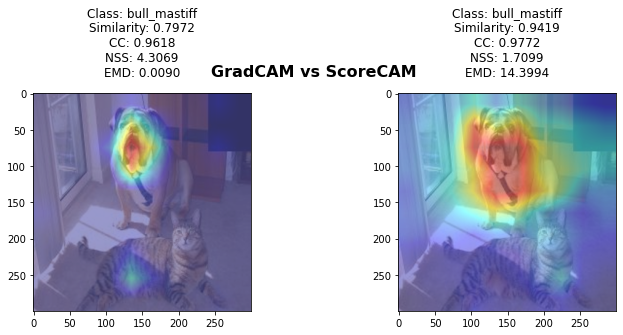

predicted class ids 243	 probability 0.15274779498577118
Iteration 13 of / 16


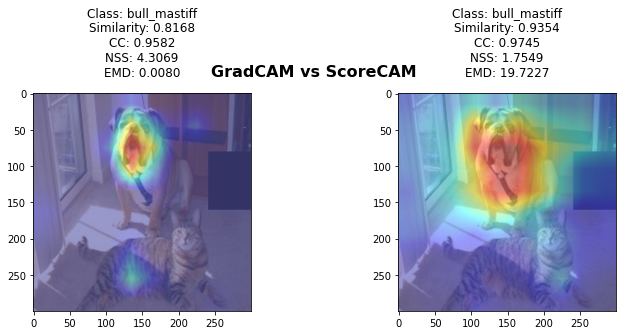

predicted class ids 243	 probability 0.17416906356811523
Iteration 14 of / 16


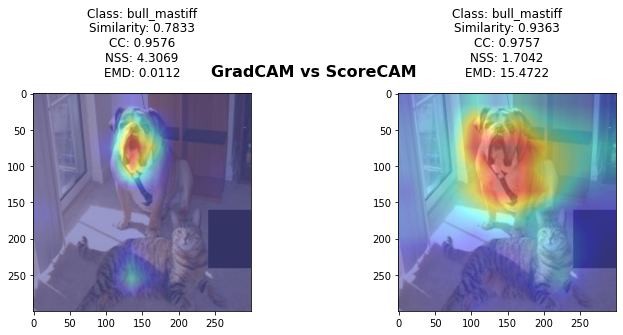

predicted class ids 243	 probability 0.16142599284648895
Iteration 15 of / 16


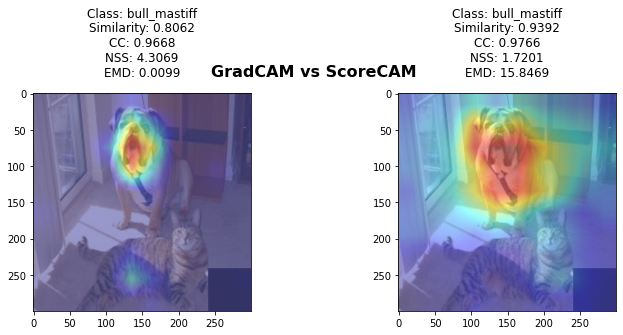

<Figure size 432x288 with 0 Axes>

In [33]:
# from numpy import random
# fig, ax = plt.subplots(count, 2, figsize=(12, 4*count))
# for i in range(0,count):
# #     img = tf.keras.preprocessing.image.load_img("/home/shkulkar/project/validating_attribution_techniques/shardul/output/noisy_images/occlusion/occluded_img_" + str(i) + ".jpg")
#     # Load the image using PIL
#     img_path = "/home/shkulkar/project/validating_attribution_techniques/shardul/output/noisy_images/occlusion/occluded_img_" + str(i) + ".jpg"
#     img = Image.open(img_path)
    
#     perturbed_tensor_grad = preprocessing(img) # calling the preprocessing function
#     perturbed_tensor_score = preprocessing(img) # calling the preprocessing function
    
#     gpu_reference_tensor = next(model_gpu.parameters())
#     perturbed_tensor_grad = perturbed_tensor_grad.type_as(gpu_reference_tensor)
#     perturbed_tensor_score = perturbed_tensor_score.type_as(gpu_reference_tensor)
    
#     perturbed_gradcam, perturbed_grad_idx = gradCAM(target_layer_gpu, model_gpu, perturbed_tensor_grad)
#     perturbed_scorecam, perturbed_score_idx = scoreCAM(target_layer_gpu, model_gpu, perturbed_tensor_score)
    
#     perturbed_gradcam = perturbed_gradcam.cpu()
#     perturbed_scorecam = perturbed_scorecam.cpu()
    
#     sim_grad, cc_grad, nss_grad, emd_grad= calculate_metrics(Gradcam, perturbed_gradcam)
#     sim_score, cc_score, nss_score, emd_score= calculate_metrics(scorecam, perturbed_scorecam)
#     print("Iteration", i , "of /", count)
# #     print("Similarity: ",sim,"\nPearson Correlation: ",cc,"\nNormalized Scanpath saliency: ", "\nEMD: ", emd)
# #     fig, ax = plt.subplots()
# #     ax.imshow(image_array, cmap = 'turbo', alpha = 0.8)
# #     fig.savefig(f"/project/validating_attribution_techniques/juneja/output/noisy_images/{i}_noise.jpeg")
# #     print(idx)
# #     print(idx2label[idx])
#     perturbed_heatmap_grad = saliency_map(perturbed_tensor_grad, perturbed_gradcam)
#     perturbed_heatmap_score = saliency_map(perturbed_tensor_score, perturbed_scorecam)
    
#     ax[i, 0].imshow(saliency_map(perturbed_tensor_grad, perturbed_gradcam), cmap='turbo', alpha=0.8)
#     ax[i, 0].set_title(f"Class: {classes[perturbed_grad_idx]}\nSimilarity: {sim_grad:.4f}\nCC: {cc_grad:.4f}\nNSS: {nss_grad:.4f}\nEMD: {emd_grad:.4f}")

#     ax[i, 1].imshow(saliency_map(perturbed_tensor_score, perturbed_scorecam), cmap='turbo', alpha=0.8)
#     ax[i, 1].set_title(f"Class: {classes[perturbed_score_idx]}\nSimilarity: {sim_score:.4f}\nCC: {cc_score:.4f}\nNSS: {nss_score:.4f}\nEMD: {emd_score:.4f}")

# # Add "GradCAM" and "ScoreCAM" labels to the entire columns
# ax[0, 0].set_title("GradCAM", fontweight="bold", fontsize=14, y=1.5)
# ax[0, 1].set_title("ScoreCAM", fontweight="bold", fontsize=14, y=1.5)

# # Adjust layout and spacing
# plt.tight_layout()
# plt.subplots_adjust(hspace=0.5)
    
# #     ax.imshow(perturbed_heatmap_grad, cmap='turbo', alpha = 0.8)
# # #     ax.set_title(f"Class: {classes[perturbed_idx]}")
# #     ax.set_title(f"Class: {classes[perturbed_grad_idx]}\nSimilarity: {sim_grad:.4f}\nCC: {cc_grad:.4f}\nNSS: {nss_grad:.4f}\nEMD: {emd_grad:.4f}")
# #     fig.savefig(f"/home/shkulkar/project/validating_attribution_techniques/shardul/output/Results/ScoreCAM/Occluded_images/{i}_{classes[perturbed_idx]}.jpg")
# # plt.savefig("saliency_heatmaps.png")
# plt.show()
# from numpy import random
# fig, ax = plt.subplots(count, 2, figsize=(12, 4*count))

gradcam_saliencies = []
scorecam_saliencies = []

for i in range(0, count):
    # Create a new figure for each iteration
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle("GradCAM vs ScoreCAM", fontsize=16, fontweight="bold")

    # Load the image using PIL
    img_path = "/home/shkulkar/project/validating_attribution_techniques/shardul/output/noisy_images/occlusion/occluded_img_" + str(i) + ".jpg"
    img = Image.open(img_path)

    perturbed_tensor_grad = preprocessing(img)  # calling the preprocessing function
    perturbed_tensor_score = preprocessing(img)  # calling the preprocessing function

    gpu_reference_tensor = next(model_gpu.parameters())
    perturbed_tensor_grad = perturbed_tensor_grad.type_as(gpu_reference_tensor)
    perturbed_tensor_score = perturbed_tensor_score.type_as(gpu_reference_tensor)

    perturbed_gradcam, perturbed_grad_idx = gradCAM(target_layer_gpu, model_gpu, perturbed_tensor_grad)
    perturbed_scorecam, perturbed_score_idx = scoreCAM(target_layer_gpu, model_gpu, perturbed_tensor_score)

    perturbed_gradcam = perturbed_gradcam.cpu()
    perturbed_scorecam = perturbed_scorecam.cpu()

    sim_grad, cc_grad, nss_grad, emd_grad = calculate_metrics(Gradcam, perturbed_gradcam, "GradCAM")
    sim_score, cc_score, nss_score, emd_score = calculate_metrics(scorecam, perturbed_scorecam, "ScoreCAM")
    print("Iteration", i, "of /", count)
    

    
    # Append the saliency maps to the respective lists
    gradcam_saliencies.append(perturbed_gradcam)
    scorecam_saliencies.append(perturbed_scorecam)
    
    # Overlay and display the saliency maps
    ax[0].imshow(saliency_map(perturbed_tensor_grad, perturbed_gradcam), cmap='turbo', alpha=0.8)
    ax[0].set_title(f"Class: {classes[perturbed_grad_idx]}\nSimilarity: {sim_grad:.4f}\nCC: {cc_grad:.4f}\nNSS: {nss_grad:.4f}\nEMD: {emd_grad:.4f}", y=1.05)

    ax[1].imshow(saliency_map(perturbed_tensor_score, perturbed_scorecam), cmap='turbo', alpha=0.8)
    ax[1].set_title(f"Class: {classes[perturbed_score_idx]}\nSimilarity: {sim_score:.4f}\nCC: {cc_score:.4f}\nNSS: {nss_score:.4f}\nEMD: {emd_score:.4f}", y=1.05)
    
    # Save or display the figure for this iteration
    plt.show()

# Adjust layout and spacing
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)


# Metrics visualisation with two sample images using ScoreCAM

1. Same class
2. Different class

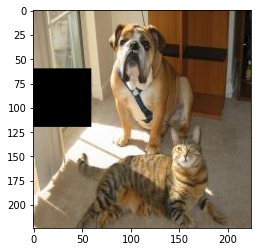

In [31]:
perturbed_image = Image.open('/home/shkulkar/project/validating_attribution_techniques/shardul/output/noisy_images/occlusion/occluded_img_1.jpg')
imshow(perturbed_image)

In [32]:
perturbed_tensor = preprocessing(perturbed_image)
perturbed_tensor.shape

torch.Size([1, 3, 300, 300])

In [33]:
gpu_reference_tensor = next(model_gpu.parameters())
perturbed_tensor = perturbed_tensor.type_as(gpu_reference_tensor)

In [34]:
perturbed_cam, perturbed_idx = scoreCAM(target_layer_gpu, model_gpu, perturbed_tensor)
perturbed_cam = perturbed_cam.cpu()

Text(0.5, 1.0, 'Class: bull_mastiff')

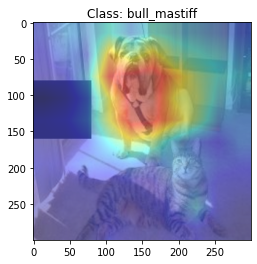

In [138]:
fig, ax = plt.subplots()
perturbed_heatmap = saliency_map(perturbed_tensor, perturbed_cam)
ax.imshow(perturbed_heatmap, cmap='turbo', alpha = 0.8)
ax.set_title(f"Class: {classes[perturbed_idx]}")

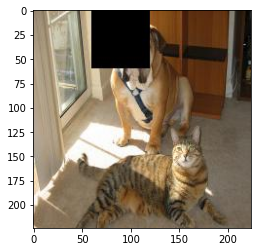

In [36]:
perturbed_image2 = Image.open('/home/shkulkar/project/validating_attribution_techniques/shardul/output/noisy_images/occlusion/occluded_img_4.jpg')
imshow(perturbed_image2)

Text(0.5, 1.0, 'Class: tabby, tabby_cat')

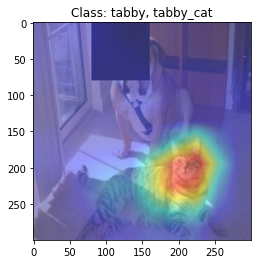

In [37]:
perturbed_tensor2 = preprocessing(perturbed_image2)
perturbed_tensor2.shape

gpu_reference_tensor = next(model.parameters())
perturbed_tensor2 = perturbed_tensor2.type_as(gpu_reference_tensor)

perturbed_cam2, perturbed_idx2 = scoreCAM(target_layer, model, perturbed_tensor2)
perturbed_cam2 = perturbed_cam2.cpu()

fig, ax = plt.subplots()
perturbed_heatmap2 = saliency_map(perturbed_tensor2, perturbed_cam2)
ax.imshow(perturbed_heatmap2, cmap='turbo', alpha = 0.8)
ax.set_title(f"Class: {classes[perturbed_idx2]}")

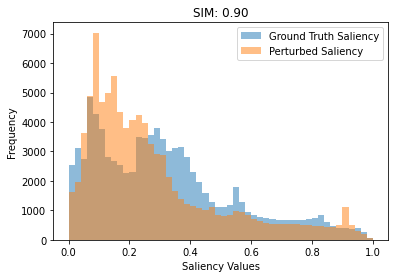

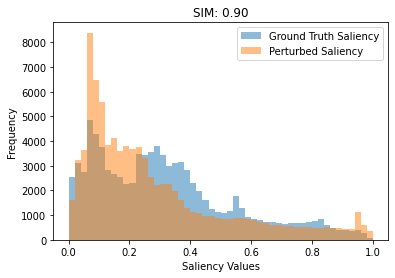

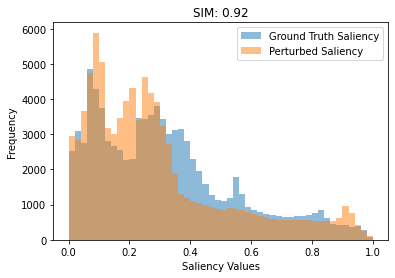

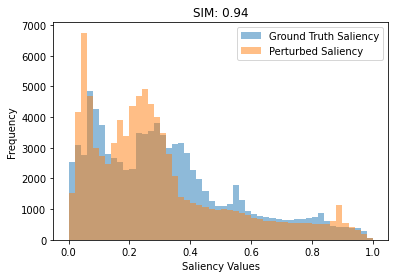

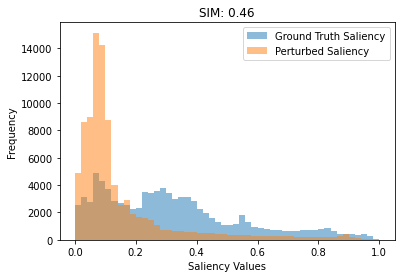

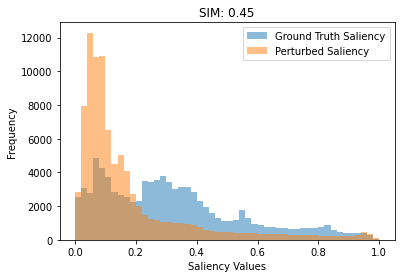

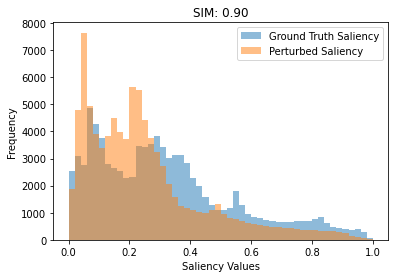

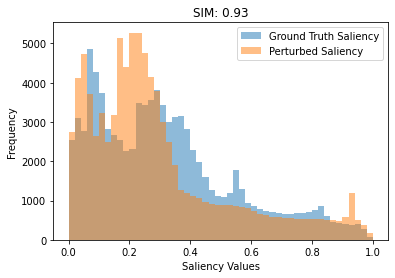

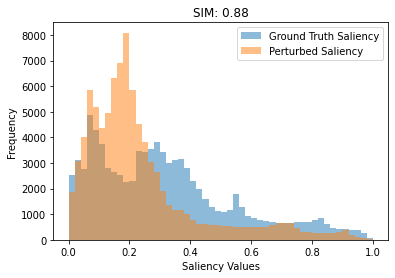

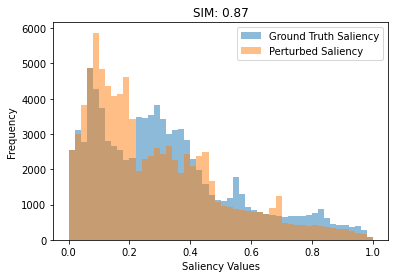

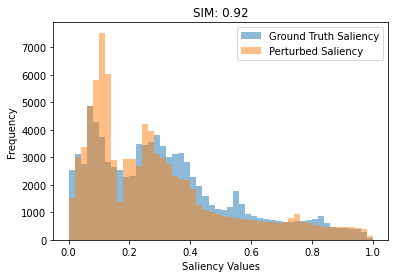

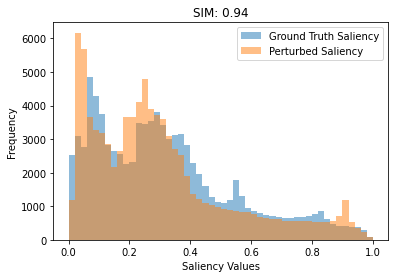

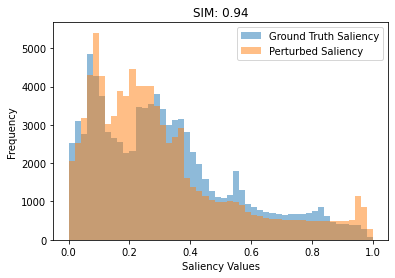

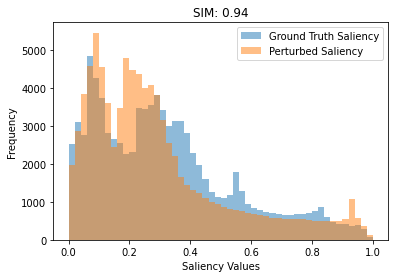

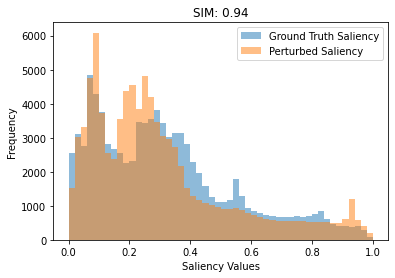

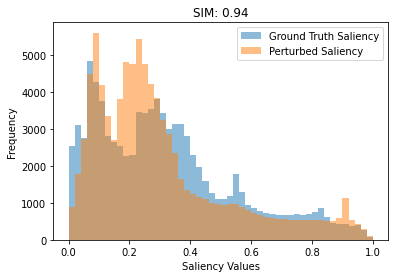

In [35]:
def visualize_SIM(saliency_map1, saliency_map2):
    """You can visualize the histogram intersection by plotting both saliency maps as histograms and showing 
    their overlap. You might create a bar plot where each bin represents a range of saliency values, and the 
    height of the bars shows the frequency of those values in each map. The area of overlap between the bars 
    of the two histograms indicates the similarity."""
    # Calculate histograms for the two saliency maps
    hist1, bins1 = np.histogram(saliency_map1, bins=50, range=(0, 1))
    hist2, bins2 = np.histogram(saliency_map2, bins=50, range=(0, 1))

    # Plot the histograms
    plt.hist(bins1[:-1], bins1, weights=hist1, alpha=0.5, label='Ground Truth Saliency')
    plt.hist(bins2[:-1], bins2, weights=hist2, alpha=0.5, label='Perturbed Saliency')
    plt.xlabel('Saliency Values')
    plt.ylabel('Frequency')
    plt.legend()
    
    #calculate SIM value
    sim = SIM(saliency_map1, saliency_map2)
    
#     plt.figtext(1.0, 0.5, f'SIM: {sim:.2f}', fontsize=12, ha='center', va='center')
    
    plt.title(f'SIM: {sim:.2f}')
    plt.show()


for i in range(len(gradcam_saliencies)):
#     visualize_SIM(Gradcam, gradcam_saliencies[i])
    visualize_SIM(scorecam, scorecam_saliencies[i])

    

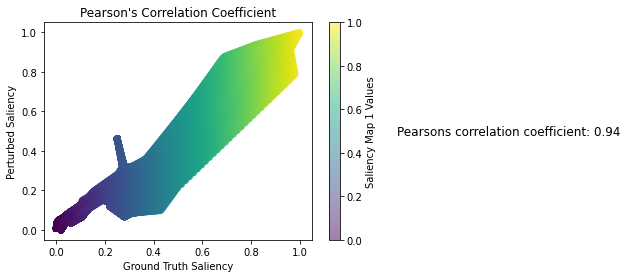

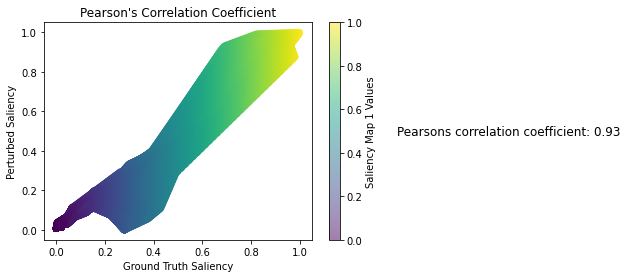

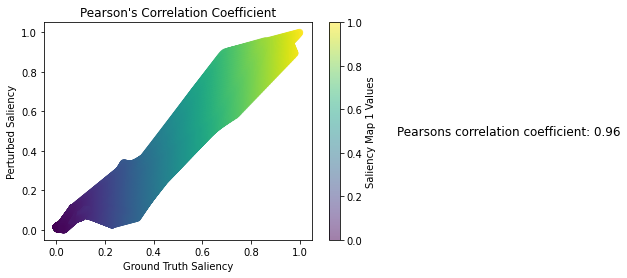

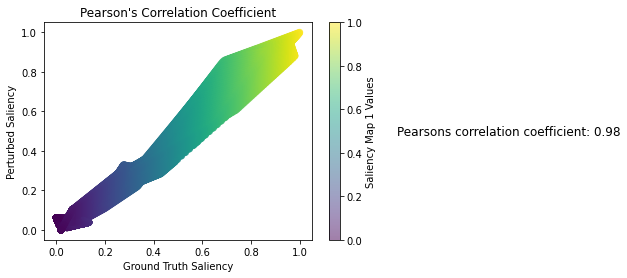

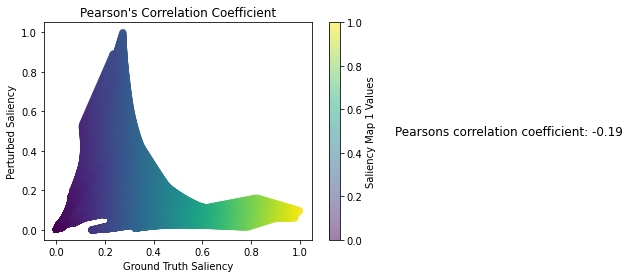

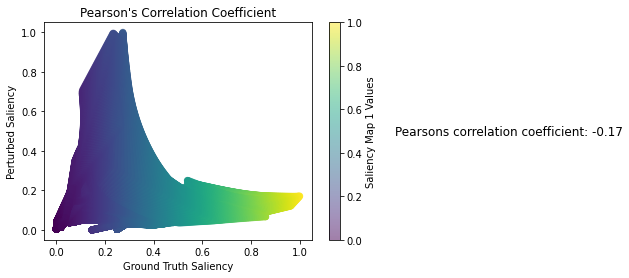

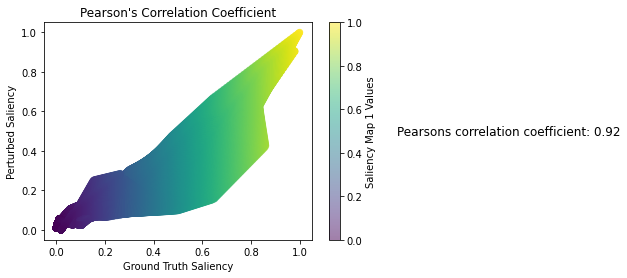

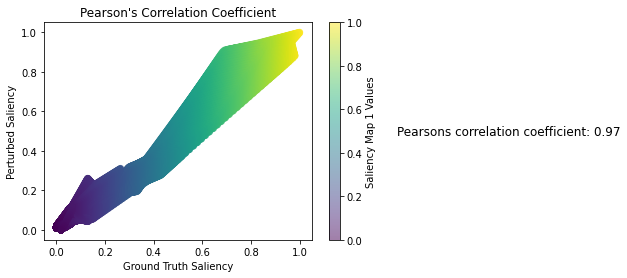

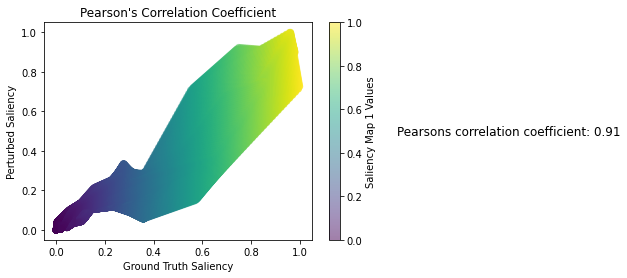

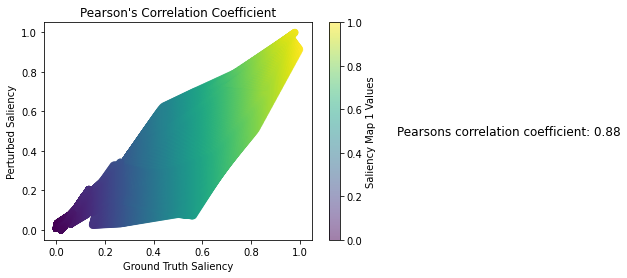

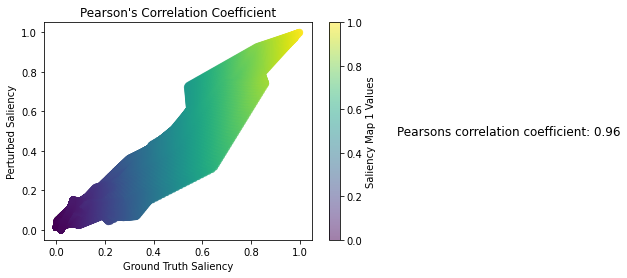

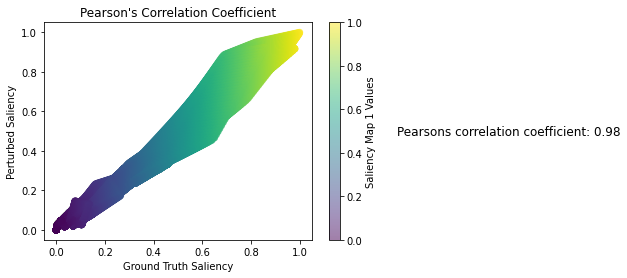

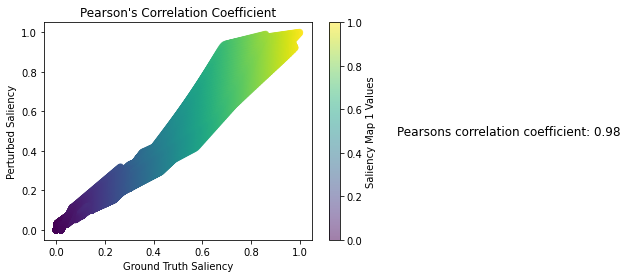

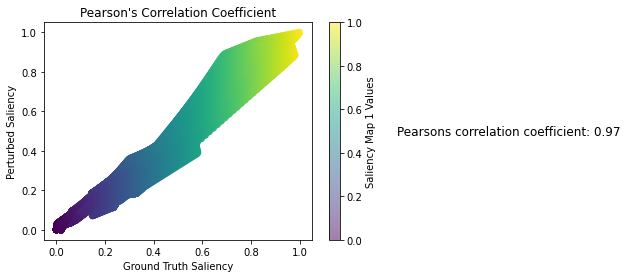

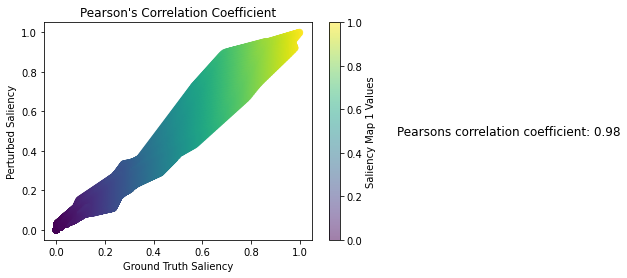

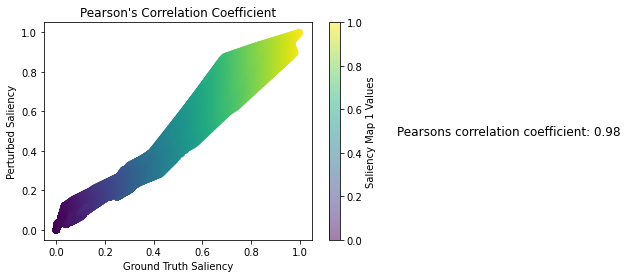

In [36]:

def visualize_CC(saliency_map1, saliency_map2):
    """To visualize the Pearson's correlation coefficient, you can create a scatter plot with points 
    representing the values at corresponding positions in both saliency maps. The closer the points 
    are to forming a straight line, the higher the correlation."""
    # Create a scatter plot with different colors for each point
    plt.scatter(saliency_map1.ravel(), saliency_map2.ravel(), c=saliency_map1.ravel(), cmap='viridis', alpha=0.5)
    plt.xlabel('Ground Truth Saliency')
    plt.ylabel('Perturbed Saliency')
    
    cc = CC(saliency_map1, saliency_map2)
    
    plt.figtext(1.2, 0.5, f'Pearsons correlation coefficient: {cc:.2f}', fontsize=12, ha='center', va='center')

    
    plt.title('Pearson\'s Correlation Coefficient')
    
    # Add a color bar to show the mapping of values to colors
    cbar = plt.colorbar()
    cbar.set_label('Saliency Map 1 Values')
    
    plt.show()

for i in range(len(gradcam_saliencies)):
#     visualize_SIM(Gradcam, gradcam_saliencies[i])
    visualize_CC(scorecam, scorecam_saliencies[i])

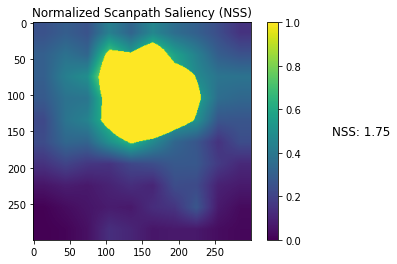

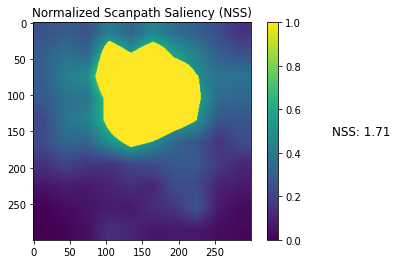

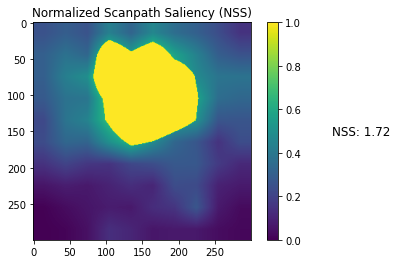

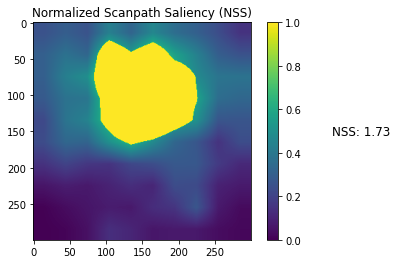

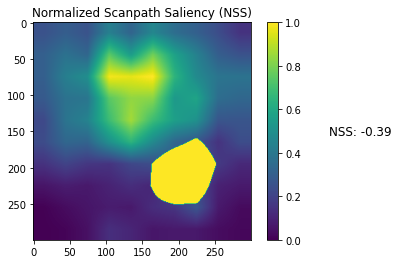

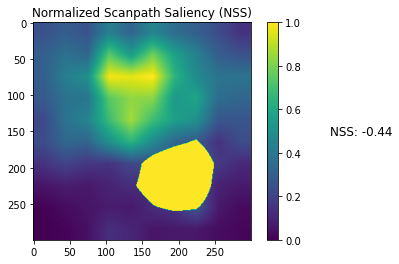

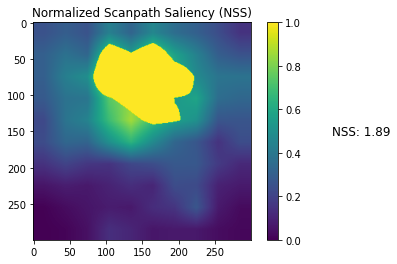

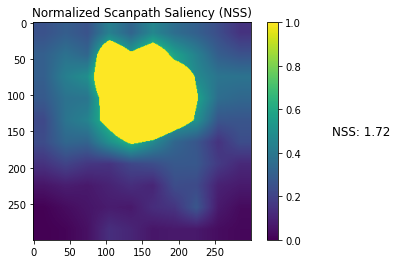

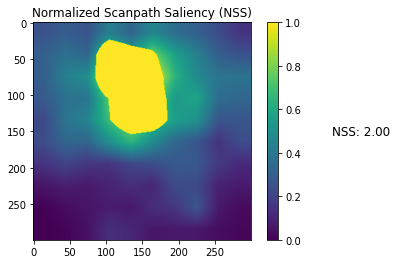

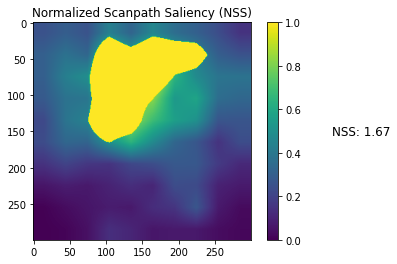

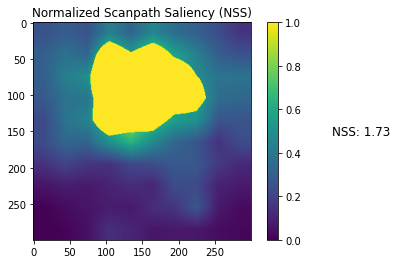

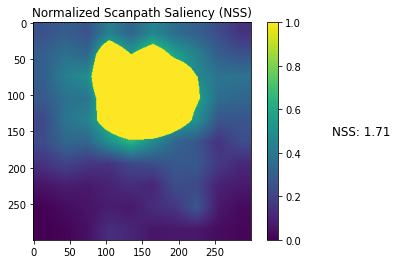

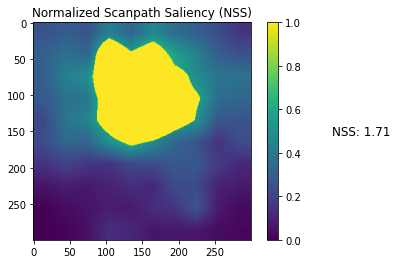

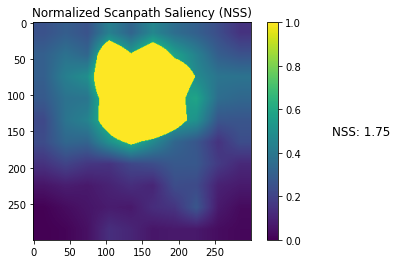

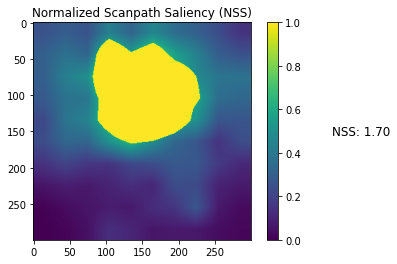

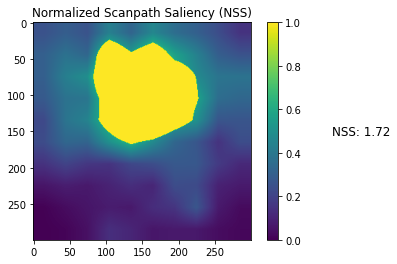

In [37]:
def visualize_NSS(cam, perturbed_cam):
    """NSS is related to the mean saliency value at fixation locations. You can visualize
    this by highlighting the fixation locations on the saliency map and showing the 
    distribution of saliency values at those locations."""
    # Convert TensorFlow tensors to NumPy arrays
    cam = cam.numpy()
    perturbed_cam = perturbed_cam.numpy()

    # Ensure that you have 2D arrays for visualization
    cam = cam[0, 0, :, :]  # Assuming (1, 1, 300, 300) shape
    perturbed_cam = perturbed_cam[0, 0, :, :]

    # Highlight fixation locations on the CAM
    cam_with_fixations = cam.copy()
    cam_with_fixations[perturbed_cam > 0.5] = cam.max()
    
    nss = NSS(cam, perturbed_cam)

    plt.imshow(cam_with_fixations, cmap='viridis')
    plt.colorbar()
    plt.figtext(1.0, 0.5, f'NSS: {nss:.2f}', fontsize=12, ha='center', va='center')
    plt.title('Normalized Scanpath Saliency (NSS)')
    plt.show()
    
for i in range(len(gradcam_saliencies)):
#     visualize_SIM(Gradcam, gradcam_saliencies[i])
    visualize_NSS(scorecam, scorecam_saliencies[i])

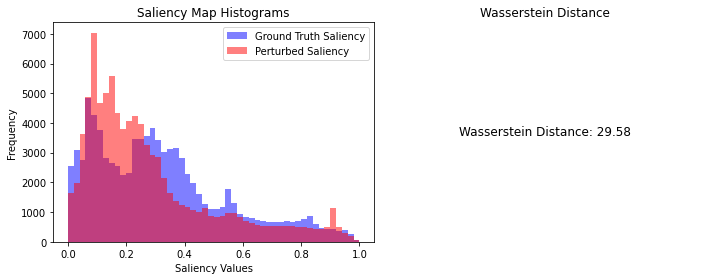

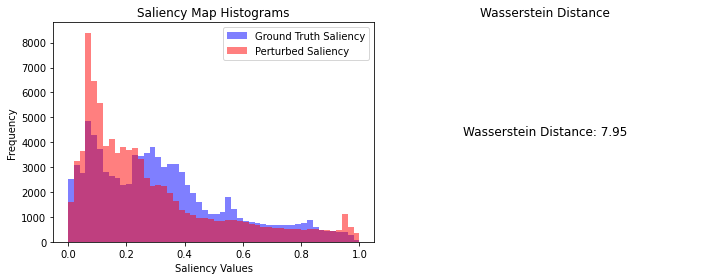

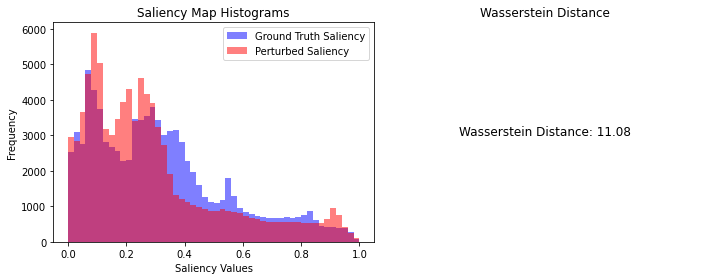

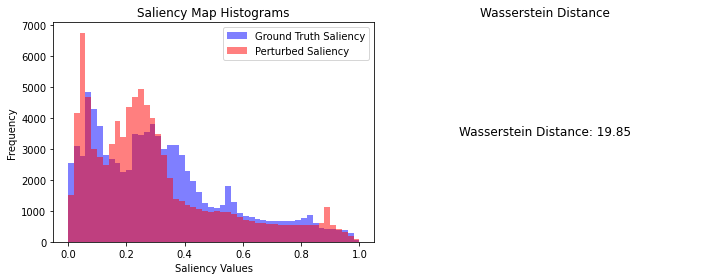

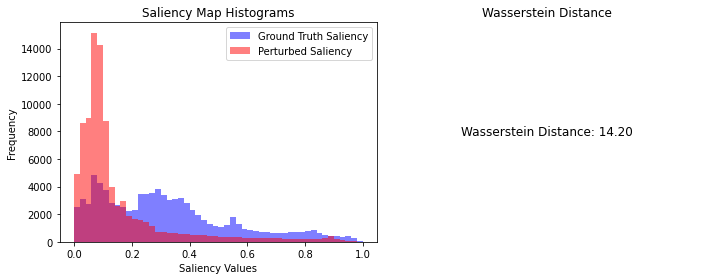

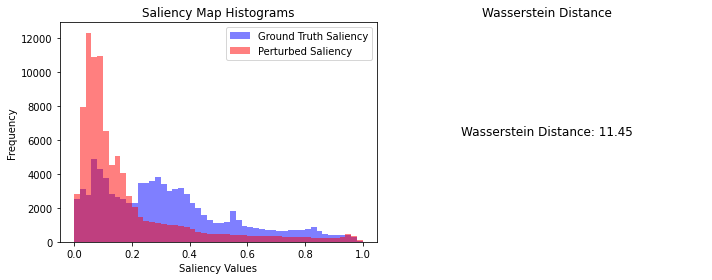

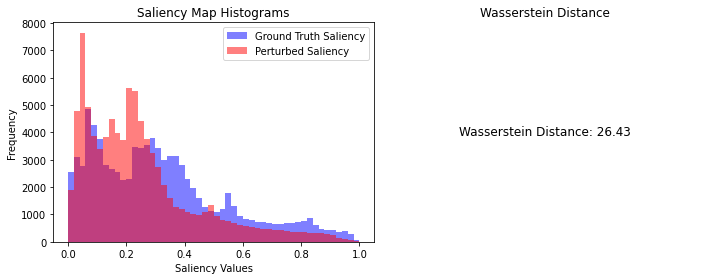

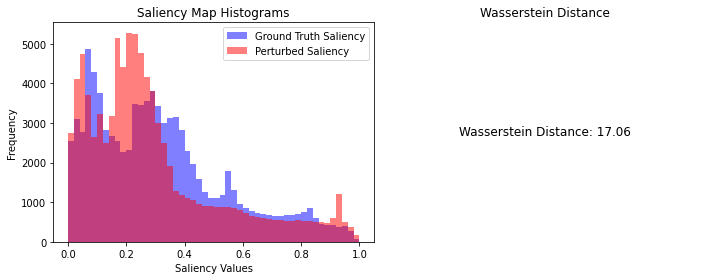

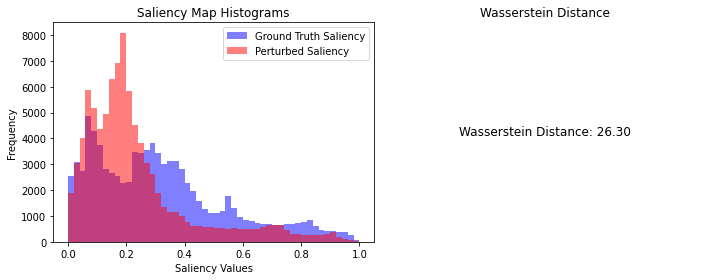

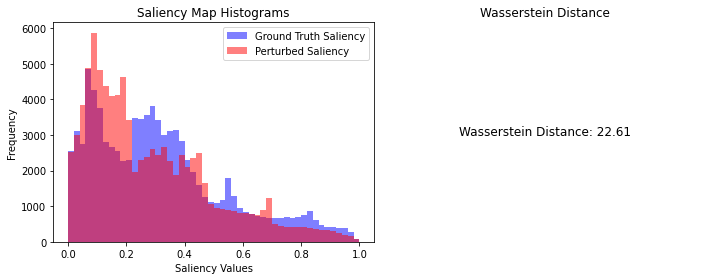

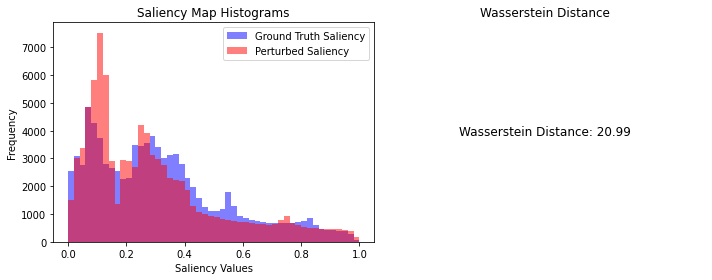

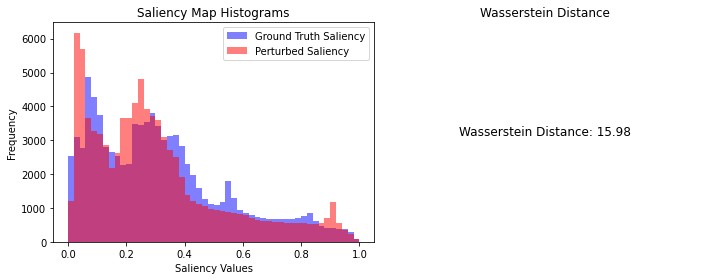

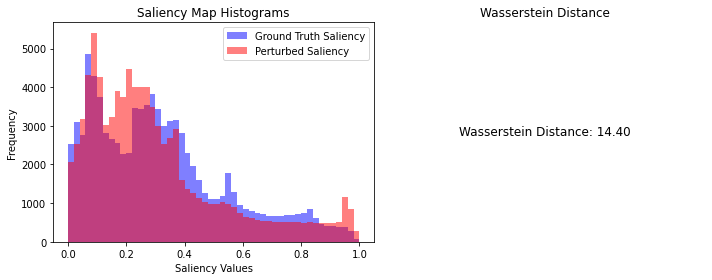

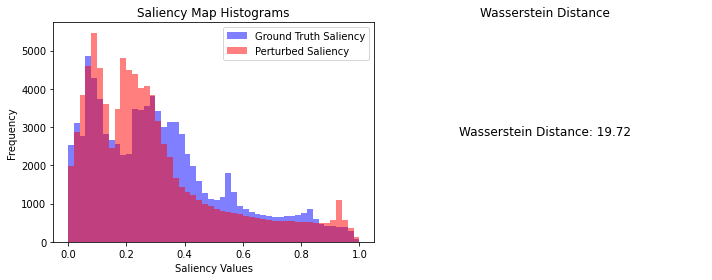

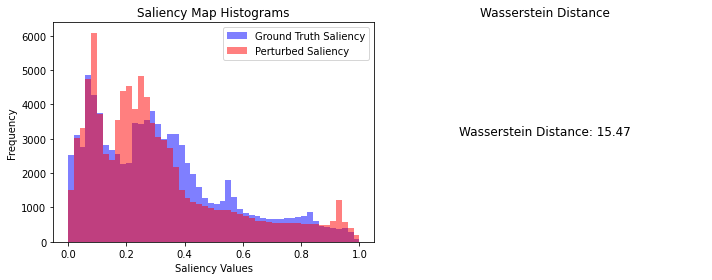

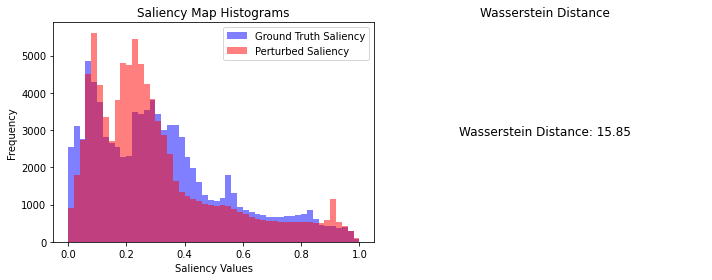

In [38]:
def visualize_Wasserstein_distance(cam, perturbed_cam):
    # Reshape the saliency maps into 1D arrays
    saliency_map1 = cam.reshape(-1)
    saliency_map2 = perturbed_cam.reshape(-1)

    # Compute the Wasserstein distance
    emd = wasserstein_distance(cam, perturbed_cam, "ScoreCAM")
    
    # Plot histograms of the two saliency maps
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(saliency_map1, bins=50, alpha=0.5, color='b', label='Ground Truth Saliency')
    plt.hist(saliency_map2, bins=50, alpha=0.5, color='r', label='Perturbed Saliency')
    plt.xlabel('Saliency Values')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('Saliency Map Histograms')

    # Display the computed Wasserstein distance
    plt.subplot(1, 2, 2)
    plt.text(0.5, 0.5, f'Wasserstein Distance: {emd:.2f}', fontsize=12, ha='center', va='center')
    plt.axis('off')
    plt.title('Wasserstein Distance')

    plt.tight_layout()
    plt.show()

for i in range(len(gradcam_saliencies)):
#     visualize_SIM(Gradcam, gradcam_saliencies[i])
    visualize_Wasserstein_distance(scorecam, scorecam_saliencies[i])

# Single Image all perturbations (Occlusion based)

# Multiple Imges

Text(0.5, 1.0, 'ScoreCAM Class: airliner(61.72%)')

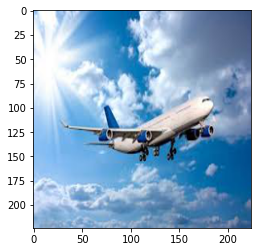

<Figure size 432x288 with 0 Axes>

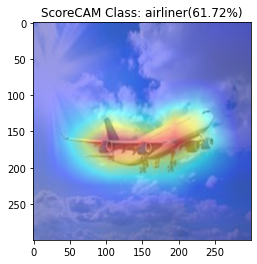

In [22]:
image = Image.open('/project/validating_attribution_techniques/commons/examples/plane.png')
# image = keras.utils.get_file("cat_and_dog.jpg", "https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg",)
imshow(image)
tensor_new = preprocessing(image)
gpu_reference_tensor = next(model_gpu.parameters())
tensor_new = tensor_new.type_as(gpu_reference_tensor)
scorecam_new, score_idx_new = scoreCAM(target_layer_gpu, model_gpu, tensor_new)
scorecam_new = scorecam_new.cpu()
# Create a new figure for each image
plt.figure()
    
fig, ax = plt.subplots()
with torch.no_grad():
  output_score_new = model_gpu(tensor_new)
  class_score_new = torch.argmax(output_score_new).item()
  prob_score_new = torch.softmax(output_score_new, dim=1)[0, class_score_new].item()
heatmap_new = saliency_map(tensor_new, scorecam_new)
ax.imshow(heatmap_new, cmap='turbo', alpha = 0.8)
ax.set_title(f"ScoreCAM Class: {idx2label[score_idx_new]}({prob_score_new*100:.2f}%)")

predicted class ids 404	 probability 0.6172493100166321


Text(0.5, 1.0, 'GradCAM Class: airliner(61.72%)')

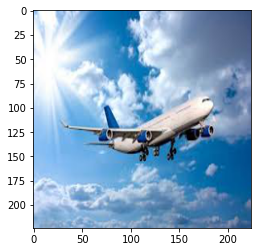

<Figure size 432x288 with 0 Axes>

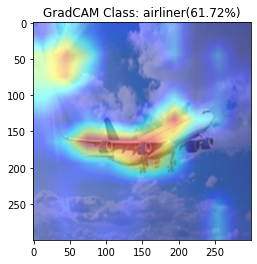

In [23]:
image = Image.open('/project/validating_attribution_techniques/commons/examples/plane.png')
# image = keras.utils.get_file("cat_and_dog.jpg", "https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg",)
imshow(image)
tensor_new_grad = preprocessing(image)
gpu_reference_tensor = next(model_gpu.parameters())
tensor_new_grad = tensor_new_grad.type_as(gpu_reference_tensor)
gradcam_new, grad_idx_new = gradCAM(target_layer_gpu, model_gpu, tensor_new_grad)
gradcam_new = gradcam_new.cpu()
# Create a new figure for each image
plt.figure()
    
fig, ax = plt.subplots()
with torch.no_grad():
  output_grad_new = model_gpu(tensor_new_grad)
  class_grad_new = torch.argmax(output_grad_new).item()
  prob_grad_new = torch.softmax(output_grad_new, dim=1)[0, class_grad_new].item()
heatmap_grad_new = saliency_map(tensor_new_grad, gradcam_new)
ax.imshow(heatmap_grad_new, cmap='turbo', alpha = 0.8)
ax.set_title(f"GradCAM Class: {idx2label[grad_idx_new]}({prob_grad_new*100:.2f}%)")

In [35]:
# from tensorflow import keras
# i =0
# PATCH_SIZE = 60
# # path = "/shardul/output/plane/After_noise/"
# image = tf.keras.preprocessing.image.load_img('/project/validating_attribution_techniques/commons/examples/plane.png', target_size=(224, 224))
# image = tf.keras.preprocessing.image.img_to_array(image)
# for top_left_x in range(0, image.shape[0], PATCH_SIZE):
#     for top_left_y in range(0, image.shape[1], PATCH_SIZE):
#         # Apply the patch and display the image
#         path = '/project/validating_attribution_techniques/shardul/output/plane/After_noise/occluded_img_' + str(i) + ".jpg"
#         i+=1
#         patched_image = apply_grey_patch(path,image, top_left_x, top_left_y, PATCH_SIZE)
#         patched_image = patched_image.astype('float32') / 255.0

predicted class ids 404	 probability 0.5564403533935547
Iteration 0 of / 16


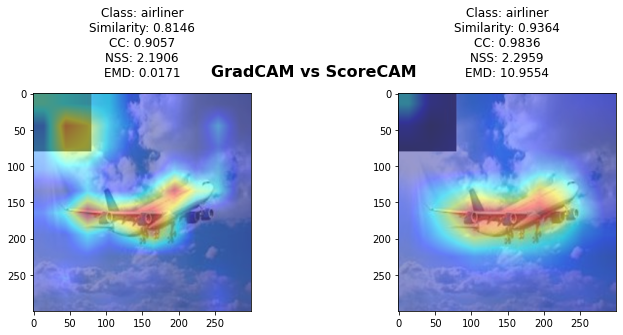

predicted class ids 404	 probability 0.4347018599510193
Iteration 1 of / 16


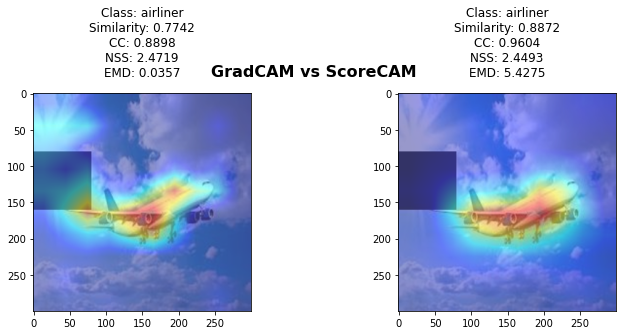

predicted class ids 404	 probability 0.38737502694129944
Iteration 2 of / 16


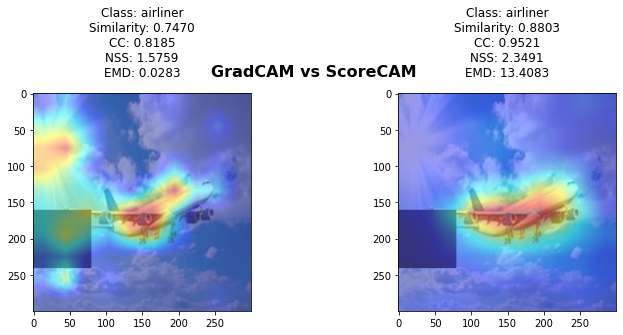

predicted class ids 404	 probability 0.53831547498703
Iteration 3 of / 16


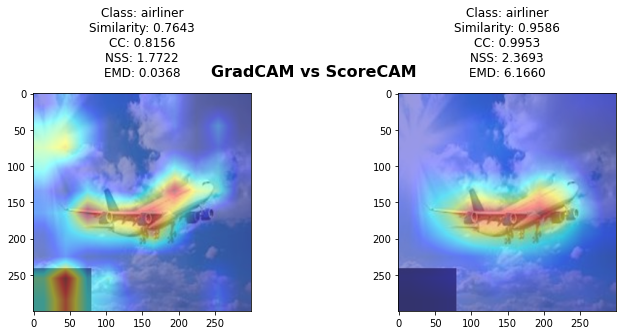

predicted class ids 404	 probability 0.46961554884910583
Iteration 4 of / 16


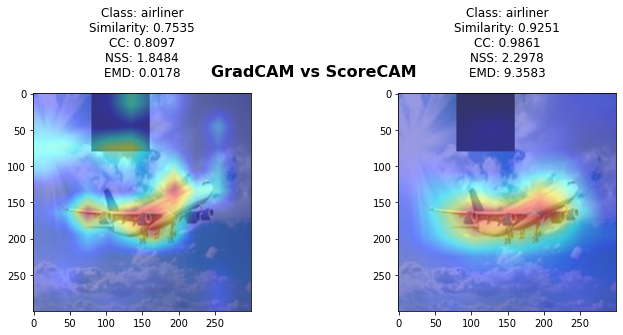

predicted class ids 404	 probability 0.2854462265968323
Iteration 5 of / 16


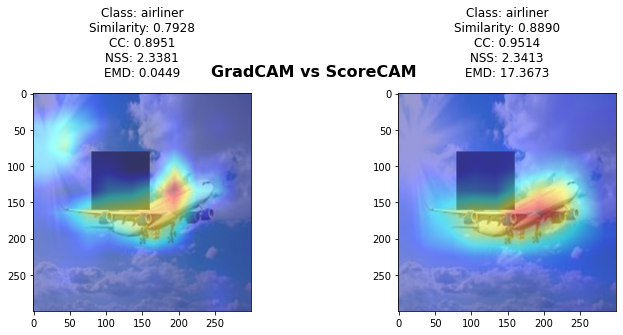

predicted class ids 812	 probability 0.5276969075202942
Iteration 6 of / 16


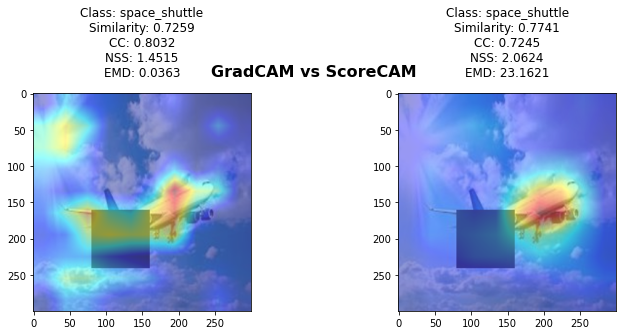

predicted class ids 404	 probability 0.49442020058631897
Iteration 7 of / 16


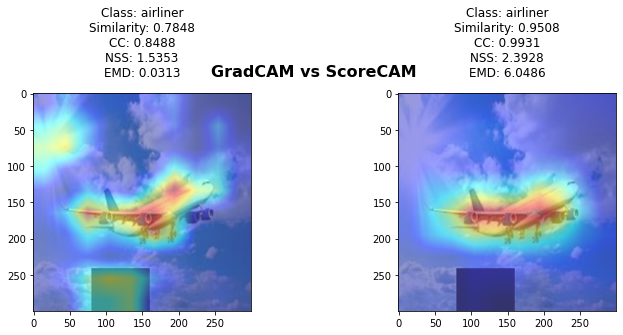

predicted class ids 404	 probability 0.5798089504241943
Iteration 8 of / 16


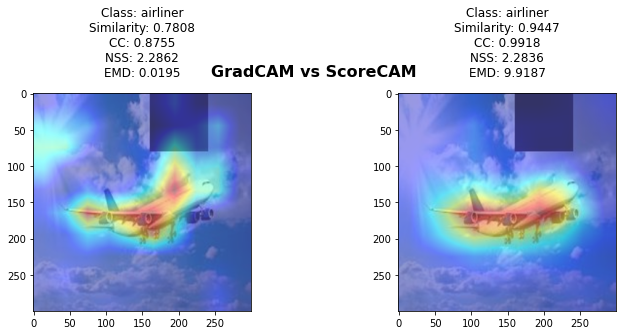

predicted class ids 782	 probability 0.2220401167869568
Iteration 9 of / 16


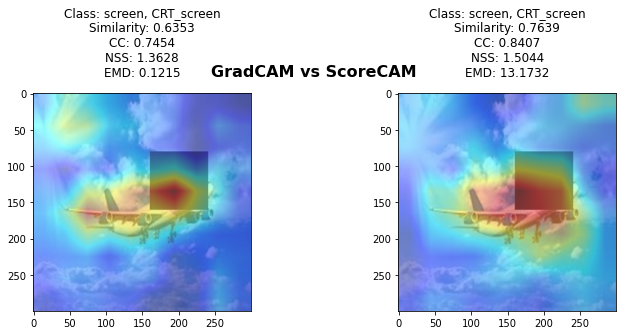

predicted class ids 812	 probability 0.4837709069252014
Iteration 10 of / 16


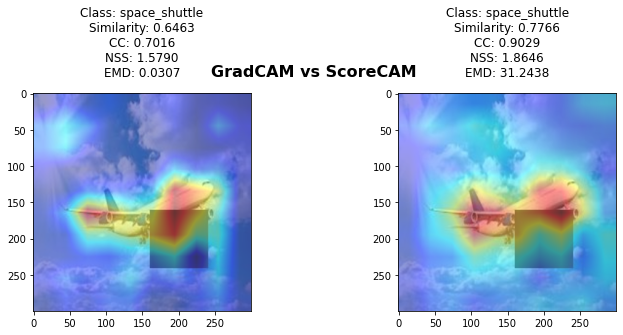

predicted class ids 404	 probability 0.507567286491394
Iteration 11 of / 16


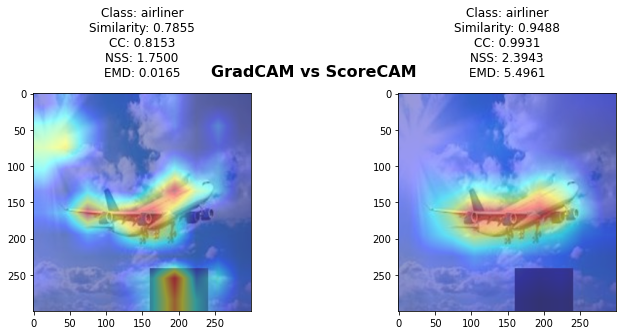

predicted class ids 404	 probability 0.621867299079895
Iteration 12 of / 16


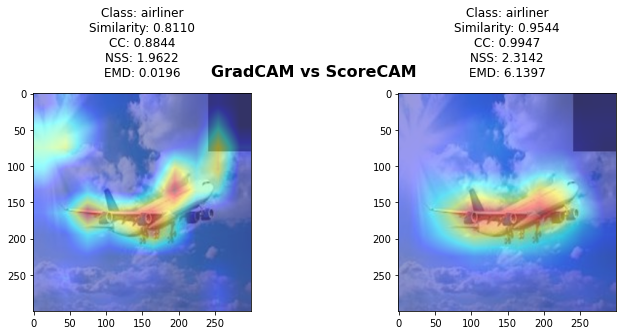

predicted class ids 404	 probability 0.45251014828681946
Iteration 13 of / 16


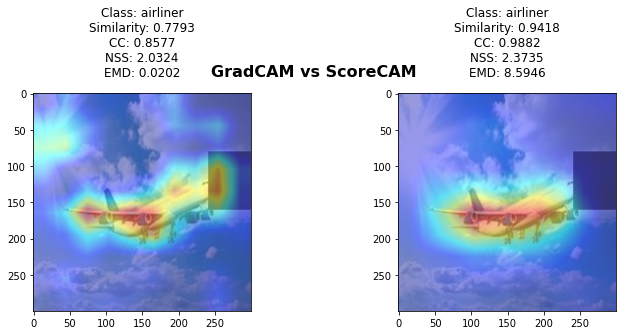

predicted class ids 404	 probability 0.5667238831520081
Iteration 14 of / 16


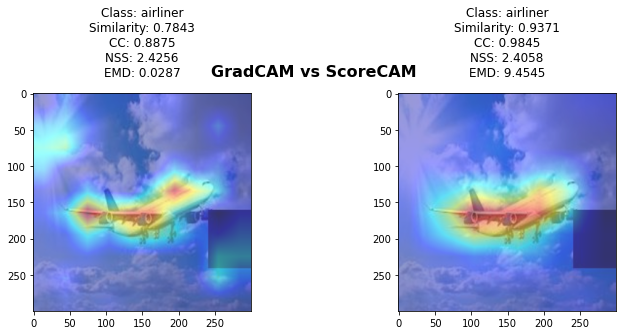

predicted class ids 404	 probability 0.5832107067108154
Iteration 15 of / 16


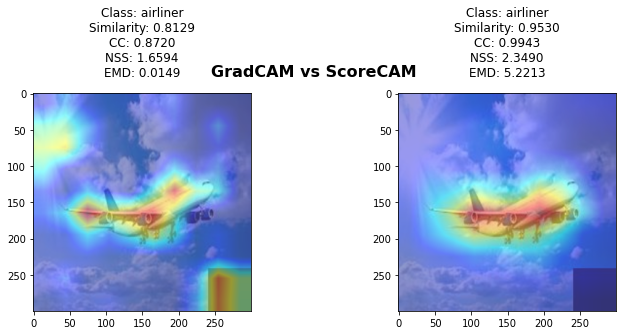

<Figure size 432x288 with 0 Axes>

In [34]:
count = 16
for i in range(0,count):
    # Create a new figure for each iteration
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle("GradCAM vs ScoreCAM", fontsize=16, fontweight="bold")

    # Load the image using PIL
    img_path = "/project/validating_attribution_techniques/shardul/output/plane/After_noise/occluded_img_" + str(i) + ".jpg"
    img = Image.open(img_path)

    perturbed_tensor_grad = preprocessing(img)  # calling the preprocessing function
    perturbed_tensor_score = preprocessing(img)  # calling the preprocessing function

    gpu_reference_tensor = next(model_gpu.parameters())
    perturbed_tensor_grad = perturbed_tensor_grad.type_as(gpu_reference_tensor)
    perturbed_tensor_score = perturbed_tensor_score.type_as(gpu_reference_tensor)

    perturbed_gradcam, perturbed_grad_idx = gradCAM(target_layer_gpu, model_gpu, perturbed_tensor_grad)
    perturbed_scorecam, perturbed_score_idx = scoreCAM(target_layer_gpu, model_gpu, perturbed_tensor_score)

    perturbed_gradcam = perturbed_gradcam.cpu()
    perturbed_scorecam = perturbed_scorecam.cpu()

    sim_grad, cc_grad, nss_grad, emd_grad = calculate_metrics(gradcam_new, perturbed_gradcam, "GradCAM")
    sim_score, cc_score, nss_score, emd_score = calculate_metrics(scorecam_new, perturbed_scorecam, "ScoreCAM")
    print("Iteration", i, "of /", count)
    

    
    # Append the saliency maps to the respective lists
#     gradcam_saliencies.append(perturbed_gradcam)
#     scorecam_saliencies.append(perturbed_scorecam)
    
#     Overlay and display the saliency maps
    ax[0].imshow(saliency_map(perturbed_tensor_grad, perturbed_gradcam), cmap='turbo', alpha=0.8)
    ax[0].set_title(f"Class: {classes[perturbed_grad_idx]}\nSimilarity: {sim_grad:.4f}\nCC: {cc_grad:.4f}\nNSS: {nss_grad:.4f}\nEMD: {emd_grad:.4f}", y=1.05)

    ax[1].imshow(saliency_map(perturbed_tensor_score, perturbed_scorecam), cmap='turbo', alpha=0.8)
    ax[1].set_title(f"Class: {classes[perturbed_score_idx]}\nSimilarity: {sim_score:.4f}\nCC: {cc_score:.4f}\nNSS: {nss_score:.4f}\nEMD: {emd_score:.4f}", y=1.05)
    
    # Save or display the figure for this iteration
    plt.show()

# Adjust layout and spacing
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)